<a href="https://colab.research.google.com/github/MS-H2020/Open/blob/main/Fune_Tune_Test8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!cp "/content/drive/MyDrive/Colab Notebooks/data.zip" .
!unzip data.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/train/1/n_05256.jpg  
  inflating: __MACOSX/data/train/1/._n_05256.jpg  
  inflating: data/train/1/n_01024.jpg  
  inflating: __MACOSX/data/train/1/._n_01024.jpg  
  inflating: data/train/1/n_03155.jpg  
  inflating: __MACOSX/data/train/1/._n_03155.jpg  
  inflating: data/train/1/n_04389.jpg  
  inflating: __MACOSX/data/train/1/._n_04389.jpg  
  inflating: data/train/1/n_03380.jpg  
  inflating: __MACOSX/data/train/1/._n_03380.jpg  
  inflating: data/train/1/n_00845.jpg  
  inflating: __MACOSX/data/train/1/._n_00845.jpg  
  inflating: data/train/1/n_04410.jpg  
  inflating: __MACOSX/data/train/1/._n_04410.jpg  
  inflating: data/train/1/n_02075.jpg  
  inflating: __MACOSX/data/train/1/._n_02075.jpg  
  inflating: data/train/1/n_04362.jpg  
  inflating: __MACOSX/data/train/1/._n_04362.jpg  
  inflating: data/train/1/n_01232.jpg  
  inflating: __MACOSX/data/train/1/._n_01232.jpg  
  inflating: data/train/1/n_00892.jpg  

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator( rescale=1./255, # 255で割ることで正規化
                              featurewise_center = False,
                              samplewise_center = False,
                              featurewise_std_normalization = False,
                              samplewise_std_normalization = False,
                              zca_whitening = False,
                              rotation_range = 10,
                              #width_shift_range = 0.3,
                              #height_shift_range = 0.3,
                              horizontal_flip = True,
                              vertical_flip = False,
                              validation_split = 0.1
                            )

In [3]:
train_dir = './data/train'
BATCH_SIZE = 32

train_generator = datagen.flow_from_directory(
            train_dir,
            target_size=(256,256),
            batch_size=BATCH_SIZE,
            class_mode='categorical',
            shuffle=True,
            subset = "training"
  )

val_generator = datagen.flow_from_directory(
            train_dir,
            target_size=(256,256),
            batch_size=BATCH_SIZE,
            class_mode='categorical',
            shuffle=True,
            subset = "validation"
)

Found 3816 images belonging to 8 classes.
Found 422 images belonging to 8 classes.


In [4]:
from tensorflow.keras.applications import densenet

IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_DEPTH = 3

base_model = densenet.DenseNet121(weights='imagenet',
                  include_top=False,
                  input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH)
                 )

base_model.trainable = True
"""
for layer in base_model.layers[-60:]:
    layer.trainable = True
"""

29084464/29084464 [==============================] - 0s 0us/step


'\nfor layer in base_model.layers[-60:]:\n    layer.trainable = True\n'

In [5]:
from tensorflow.keras import datasets, layers, models, applications, optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten

CATEGORY_NUM = 8

model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(512, activation='relu'),
    layers.Dense(CATEGORY_NUM, activation='softmax')
])

adam_low_rate = optimizers.Adam(learning_rate=0.001)

In [6]:
# モデルの概要
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 8, 8, 1024)        7037504   
                                                                 
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 dense (Dense)               (None, 1024)              67109888  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               2

In [7]:
# モデルを構築
model.compile(optimizer=adam_low_rate,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [8]:
from tensorflow import keras

# Early stoppingを適用してフィッティング
log = model.fit(
                  train_generator,
                  validation_data = val_generator,
                  steps_per_epoch = train_generator.samples // BATCH_SIZE,
                  validation_steps = val_generator.samples // BATCH_SIZE,
                  verbose=True,
                  callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)],
                  epochs = 20,
                  workers = 1
)

Epoch 1/20
119/119 [==============================] - 173s 796ms/step - loss: 5.4439 - accuracy: 0.2801 - val_loss: 2263.5474 - val_accuracy: 0.1490
Epoch 2/20
119/119 [==============================] - 88s 737ms/step - loss: 1.7139 - accuracy: 0.3243 - val_loss: 6.4468 - val_accuracy: 0.3365
Epoch 3/20
119/119 [==============================] - 89s 750ms/step - loss: 1.5151 - accuracy: 0.3882 - val_loss: 1.4340 - val_accuracy: 0.4495
Epoch 4/20
119/119 [==============================] - 87s 733ms/step - loss: 1.3865 - accuracy: 0.4672 - val_loss: 1.3705 - val_accuracy: 0.4615
Epoch 5/20
119/119 [==============================] - 85s 716ms/step - loss: 1.2772 - accuracy: 0.5233 - val_loss: 2.5543 - val_accuracy: 0.3870
Epoch 6/20
119/119 [==============================] - 86s 724ms/step - loss: 1.2369 - accuracy: 0.5499 - val_loss: 1.3628 - val_accuracy: 0.4639
Epoch 7/20
119/119 [==============================] - 85s 715ms/step - loss: 1.1336 - accuracy: 0.5996 - val_loss: 1.0721 - va

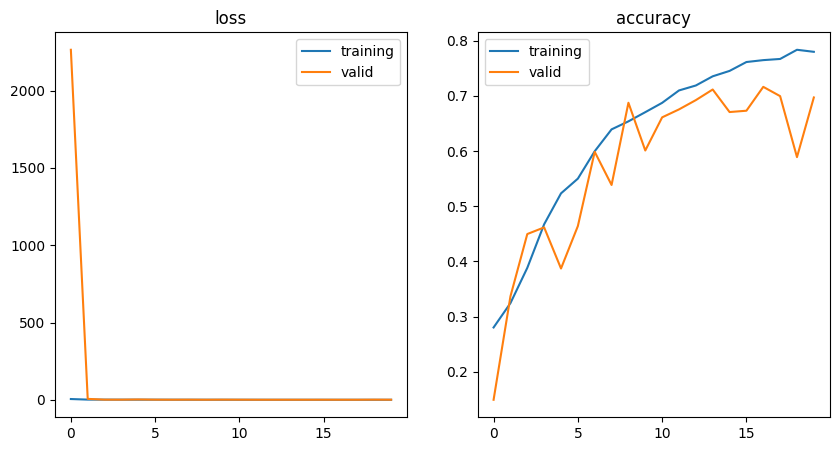

In [9]:
import matplotlib.pyplot as plt
metrics = ['loss', 'accuracy']  # 使用する評価関数を指定
plt.figure(figsize=(10, 5))  # グラフを表示するスペースを用意

for i in range(len(metrics)):

    metric = metrics[i]

    plt.subplot(1, 2, i+1)  # figureを1×2のスペースに分ける
    plt.title(metric)

    plt_train = log.history[metric]
    plt_valid  = log.history['val_' + metric]

    plt.plot(plt_train, label='training')
    plt.plot(plt_valid, label='valid')
    plt.legend()

plt.savefig("metrics.jpg")

In [10]:
#Confution Matrix and Classification Report
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

Y_pred = model.predict(val_generator, val_generator.samples // BATCH_SIZE)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(val_generator.classes, y_pred))
print('Classification Report')
print(classification_report(val_generator.classes, y_pred, target_names=None))

14/14 [==============================] - 11s 652ms/step
Confusion Matrix
[[28 59  7  6 20  1  0]
 [36 60  3  9 21  0  0]
 [13 13  3  2  6  0  0]
 [ 7 10  1  6 12  1  0]
 [22 34  4  3 20  0  0]
 [ 2  2  0  0  1  0  0]
 [ 4  4  0  0  1  1  0]]
Classification Report
              precision    recall  f1-score   support

           0       0.25      0.23      0.24       121
           1       0.33      0.47      0.39       129
           2       0.17      0.08      0.11        37
           3       0.23      0.16      0.19        37
           4       0.25      0.24      0.24        83
           6       0.00      0.00      0.00         5
           7       0.00      0.00      0.00        10

    accuracy                           0.28       422
   macro avg       0.17      0.17      0.17       422
weighted avg       0.26      0.28      0.26       422



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(50.722222222222214, 0.5, 'true')

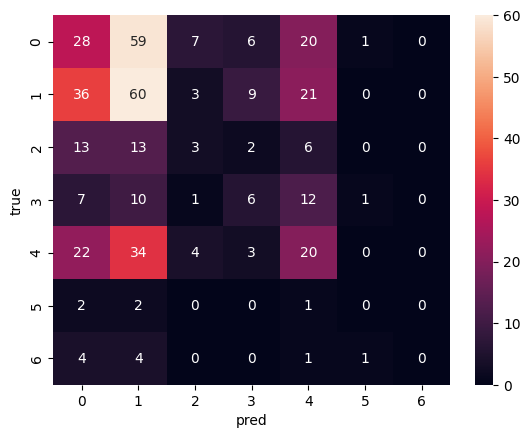

In [11]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.heatmap(confusion_matrix(val_generator.classes, y_pred), annot=True)
plt.xlabel("pred")
plt.ylabel('true')

In [12]:
# 評価する。
test_loss, test_acc = model.evaluate(val_generator)

print(f"test loss: {test_loss:.2f}, test accuracy: {test_acc:.2%}")
#model.save('/content/drive/MyDrive/Colab Notebooks/cnn_dense121.h5')

14/14 [==============================] - 6s 437ms/step - loss: 1.0478 - accuracy: 0.6825
test loss: 1.05, test accuracy: 68.25%


In [13]:
#from tensorflow.keras.models import Model, load_model
#model = load_model('/content/drive/MyDrive/Colab Notebooks/cnn_dense121.h5')

In [14]:
test_dir = './data/test'

import os
import shutil
import glob

os.makedirs('./data/test/dummy', exist_ok=True)
for image_path in glob.glob(test_dir + '/*'):
    shutil.move(image_path, test_dir + '/dummy')

In [15]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(256,256), batch_size=64, class_mode=None, shuffle=False)

Found 1060 images belonging to 1 classes.


In [16]:
import numpy as np
prediction = model.predict(test_generator)
results = np.argmax(prediction,axis=1)
print(results)
np.savetxt('/content/drive/MyDrive/Colab Notebooks/save_ored.csv', results, delimiter=',')

17/17 [==============================] - 17s 512ms/step
[1 1 4 ... 2 0 1]
